NoteBookLink:

https://colab.research.google.com/drive/1l4JTn2MY-gIIkkqc754kZHRBfzOEWc1p?usp=drive_link

#**Airbnb Booking Demand**



#**Part I - Introduction**

##**1. Problem Objective and Target Definition**

Short-term rentals are an important part of Boston’s housing and tourism market, and Airbnb hosts care a lot about how often their listings get booked. In this project, we study how well we can predict the occupancy rate of individual Airbnb listings in Boston using datasets from InsideAirbnb the calendar, listings, and reviews data.
- Target Variable: Occupancy Rate
  - Define occupancy over the period 2016-09-05 to 2017-09-04 as:
      
     **occupancy=1−AVG(availability)**

  - In the calender data:
    - `t` = 1 means the listing is available
    - `f` = 0 means the listing is booked
- Prediction target is this listing-level occupancy rate between 0 and 1.
- Unit: Listing
  - Calendar and review data are first summarized at the listing level and then merged with listing attributes.


##**2. Stakeholder Relevance and Practical Motivation**

Predicting occupancy is practically essential for several groups:
- Hosts and property managers.

  They rely on expected occupancy to decide nightly prices, minimum-night rules, and renovation priorities. Even a rough forecast can help reduce empty nights and smooth income.

- Platform operators such as Airbnb.

  The platform can use occupancy models to design search ranking, dynamic pricing tools, and host onboarding strategies by neighborhood and season.

- Short-term rental investors and real-estate developers.

  Occupancy expectations enter directly into revenue projections when evaluating whether a new listing or building is financially viable.

- City planners and tourism bodies.

  Understanding which neighborhoods sustain high occupancy over time helps them monitor housing pressure and plan infrastructure for tourism.

Because occupancy is hard to predict in advance and is closely tied to revenue and regulation, building and evaluating prediction models on real Boston data is useful both academically and in practice.



##**3. Data Sources and Feature Overview**

We will use the Boston Airbnb Open Data from Kaggle. This dataset is part of InsideAirbnb, and the source can be found at [Get the Data | Inside Airbnb](https://insideairbnb.com/get-the-data/). The data we are using range from  2016-09-05 to 2017-09-04. They were collected because guests and hosts have used Airbnb to travel in a more unique, personalized way since 2008. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Boston, MA.

* Dataset
  - `Calendar.csv`: 1,048,576 rows, 4 columns, type: int, object, datetime
    
    We use this file to compute occupancy and to summarize availability over the one-year period.
  - `Listing.csv`: 3585 rows, 95 columns, type: int, float, object
    
    In our models, we mainly use: `id`, `price`, `room_type`, `property_type`, `accommodates`, `bathrooms`, `bedrooms`, `beds`, `number_of_reviews`, `review_scores_rating`, `reviews_per_month`, `host_is_superhost`, `host_total_listings_count`, `neighbourhood_cleansed`, `latitude`, `longitude`.
  
    These variables describe the physical characteristics of the listing, host experience, reputation, and location.
  - `Reviews.csv`: 68,275 rows, 6 columns, type: int, object
    
    Contains listing_id, review date, and text comments.
    
We restrict all three files to the same one-year window to keep the target and features aligned in time.

Calendar data are summarized at the listing level to compute occupancy and merged with listing attributes (including review-based metrics already stored in listings.csv). We do not use the raw review text in modeling.


##**4. Exploratory Insights and Modeling Motivation**

Our exploratory analysis revealed that occupancy rates among Boston Airbnb listings are highly heterogeneous, with a bimodal distribution indicating that many listings are either rarely booked or consistently occupied. We found that entire homes/apartments tend to have higher occupancy than shared rooms, and central neighborhoods like Mission Hill and Allston sustain stronger demand. Listings with more reviews show higher booking rates, suggesting the importance of reputation, while price exhibits a nonlinear relationship with occupancy, very low and mid-range prices perform best. These insights motivated our modeling approach by highlighting the need to capture complex, nonlinear patterns.

#**Part II - Analytics Processes**

## **0. Environment Setup and LIbrary Imports**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import mean_squared_error, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_airbnblisiting = '/content/drive/MyDrive/ML_Team Project_Team_3/Airbnb Dataset/listings.csv'
listing = pd.read_csv(data_airbnblisiting)
listing.info()
listing.describe()
listing.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [ ]:
data_airbnbcalendar = '/content/drive/MyDrive/ML_Team Project_Team_3/Airbnb Dataset/calendar.csv'
calendar = pd.read_csv(data_airbnbcalendar)
calendar.info()
calendar.describe()
calendar.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


## **1. Data Cleaning and Transformation**

In [ ]:
# Clean calendar: build occupancy_rate

# Convert date to datetime
calendar["date"] = pd.to_datetime(calendar["date"])

# Filter to the 1 year
start_date = pd.to_datetime("2016-09-05")
end_date   = pd.to_datetime("2017-09-04")

valid_dates = (calendar["date"] >= start_date) & (calendar["date"] <= end_date)
calendar = calendar.loc[valid_dates].copy()

# availability: "t" = available, "f" = booked
calendar["available"] = calendar["available"].replace({"t": 1, "f": 0})


# Aggregate to listing-level: mean availability → occupancy
cal_agg = (
    calendar
    .groupby("listing_id", as_index=False)
    .agg(
        availability_mean=("available", "mean")
    )
)

cal_agg["occupancy_rate"] = 1 - cal_agg["availability_mean"]

# Keep only what we need
cal_agg = cal_agg[["listing_id", "occupancy_rate"]]

print("Aggregated calendar shape:", cal_agg.shape)
print(cal_agg.head())

Aggregated calendar shape: (3585, 2)
   listing_id  occupancy_rate
0        3353        0.318681
1        5506        0.057692
2        6695        0.112637
3        6976        0.126374
4        8792        0.321429


/tmp/ipython-input-2432201641.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  calendar["available"] = calendar["available"].replace({"t": 1, "f": 0})


In [ ]:
# Clean Listing:

# Price in listings
listing["price"] = (
    listing["price"]
    .replace(r'[$,]', '', regex=True)
    .astype(float)
)

# host_is_superhost: "t"/"f" -> 1/0
listing["host_is_superhost"] = listing["host_is_superhost"].replace({"t": 1, "f": 0})

numeric_features = [
    "price",
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "number_of_reviews",
    "review_scores_rating",
    "reviews_per_month",
    "host_is_superhost",
    "host_total_listings_count",
    "latitude",
    "longitude",
    "minimum_nights",
]

categorical_features = [
    "room_type",
    "property_type",
    "neighbourhood_cleansed",
]

# Subset listings to only columns we care about + id
cols_selected = ["id"] + numeric_features + categorical_features
listing = listing[cols_selected]

print("Listings shape:", listing.shape)
print(listing.head())


Listings shape: (3585, 17)
         id  price  accommodates  bathrooms  bedrooms  beds  \
0  12147973  250.0             4        1.5       2.0   3.0   
1   3075044   65.0             2        1.0       1.0   1.0   
2      6976   65.0             2        1.0       1.0   1.0   
3   1436513   75.0             4        1.0       1.0   2.0   
4   7651065   79.0             2        1.5       1.0   2.0   

   number_of_reviews  review_scores_rating  reviews_per_month  \
0                  0                   NaN                NaN   
1                 36                  94.0               1.30   
2                 41                  98.0               0.47   
3                  1                 100.0               1.00   
4                 29                  99.0               2.25   

   host_is_superhost  host_total_listings_count   latitude  longitude  \
0                  0                          1  42.282619 -71.133068   
1                  0                          1  42.28624

/tmp/ipython-input-3455718328.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  listing["host_is_superhost"] = listing["host_is_superhost"].replace({"t": 1, "f": 0})


In [ ]:
#Merge listings + aggregated calendar

merged = listing.merge(
    cal_agg,
    left_on="id",
    right_on="listing_id",
    how="left"
)

# Drop listings that don’t have occupancy info
merged = merged.dropna(subset=["occupancy_rate"])

# Drop duplicate id column, leave id and drop listing_id
merged = merged.drop(columns=['listing_id'])

print("Merged shape:", merged.shape)
print(merged[["id", "occupancy_rate"]].head())

Merged shape: (3585, 18)
         id  occupancy_rate
0  12147973        1.000000
1   3075044        0.016484
2      6976        0.126374
3   1436513        0.730769
4   7651065        0.085165


## **2. EDA**

In [ ]:
merged.info()
print(merged.describe())
merged.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         3585 non-null   int64  
 1   price                      3585 non-null   float64
 2   accommodates               3585 non-null   int64  
 3   bathrooms                  3571 non-null   float64
 4   bedrooms                   3575 non-null   float64
 5   beds                       3576 non-null   float64
 6   number_of_reviews          3585 non-null   int64  
 7   review_scores_rating       2772 non-null   float64
 8   reviews_per_month          2829 non-null   float64
 9   host_is_superhost          3585 non-null   int64  
 10  host_total_listings_count  3585 non-null   int64  
 11  latitude                   3585 non-null   float64
 12  longitude                  3585 non-null   float64
 13  minimum_nights             3585 non-null   int64

,0
review_scores_rating,813
reviews_per_month,756
bathrooms,14
bedrooms,10
beds,9
property_type,3
price,0
id,0
number_of_reviews,0
accommodates,0


Some key features have missing values, including review_scores_rating, reviews_per_month, which will be handled using imputation in modeling.

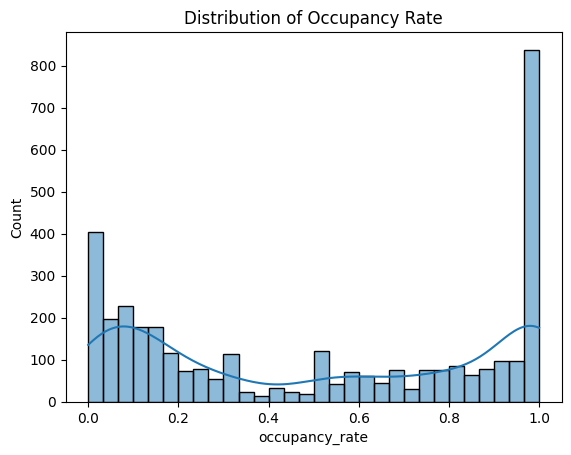

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(merged["occupancy_rate"], kde=True, bins=30)
plt.title("Distribution of Occupancy Rate")
plt.show()


The occupancy rate shows a bimodal distribution, with many listings experiencing either very low occupancy (0–0.1) or very high occupancy (0.9–1.0). This suggests heterogeneous booking patterns: some listings are consistently popular while others rarely get booked.

In [ ]:
numeric_for_corr = numeric_features + ["occupancy_rate"]
df_corr = merged[numeric_for_corr].dropna()
corr_with_target = df_corr.corr()["occupancy_rate"].sort_values(ascending=False)
corr_with_target

,occupancy_rate
occupancy_rate,1.000000
latitude,0.102162
review_scores_rating,0.078235
minimum_nights,-0.019190
longitude,-0.034651
reviews_per_month,-0.041881
host_is_superhost,-0.044965
host_total_listings_count,-0.046156
bedrooms,-0.047804
beds,-0.061040


In our dataset, the maximum absolute correlation between any numeric feature and occupancy is about 0.20 (for number_of_reviews), and most other features have |r| < 0.10. This indicates extremely weak linear relationships, implying that occupancy cannot be explained by any single variable alone. As a result, nonlinear models are expected to perform better than purely linear approaches.

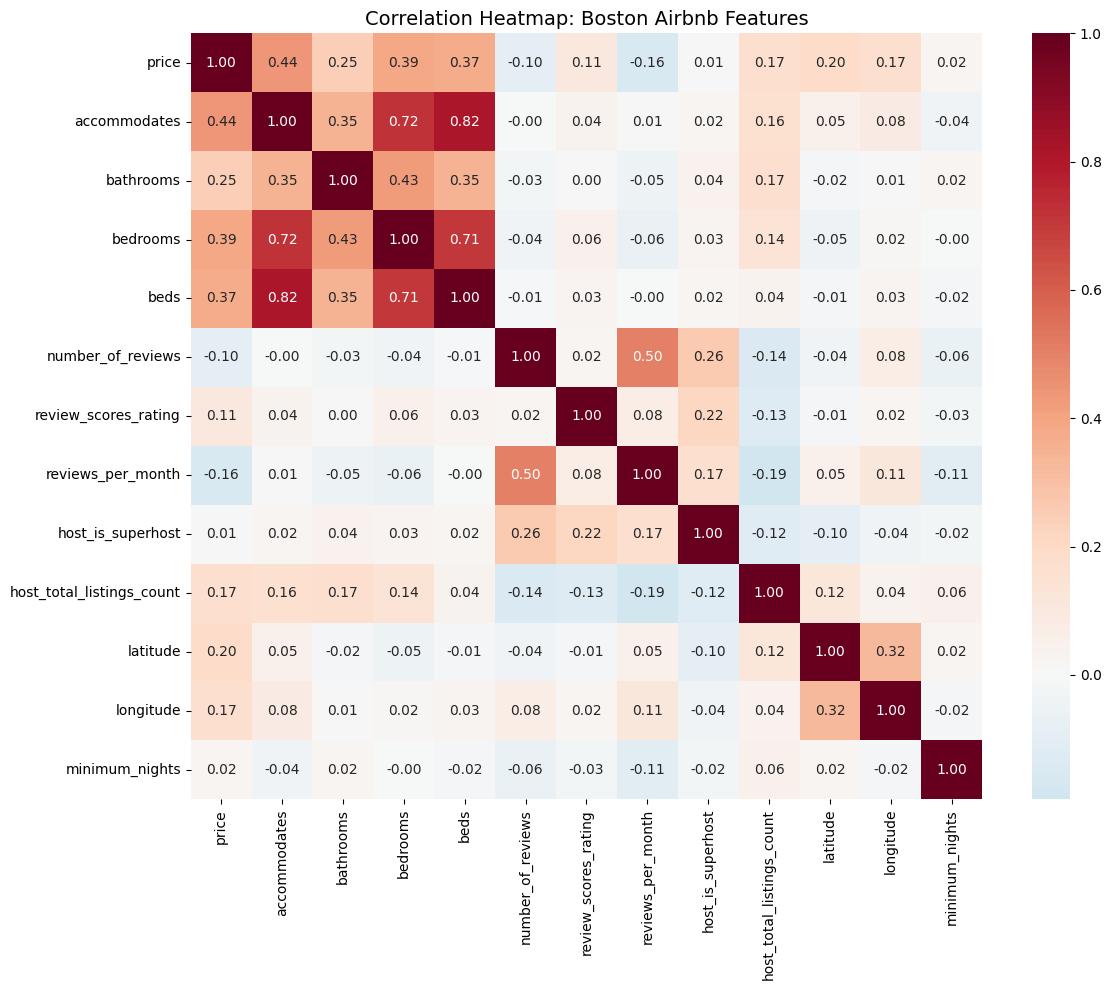

In [ ]:
corr_matrix = merged[numeric_features].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0)

plt.title("Correlation Heatmap: Boston Airbnb Features", fontsize=14)
plt.tight_layout()
plt.show()

The correlation heatmap reveals substantial multicollinearity among size-related attributes (beds, bedrooms, bathrooms, accommodates), indicating that these features represent a common latent factor: listing size. Review-related variables show moderate correlations (r ≈ 0.50), suggesting a relationship between historical and recent demand. Most other features exhibit weak correlations, offering complementary information. This pattern motivates the use of nonlinear models to capture complex feature interactions.

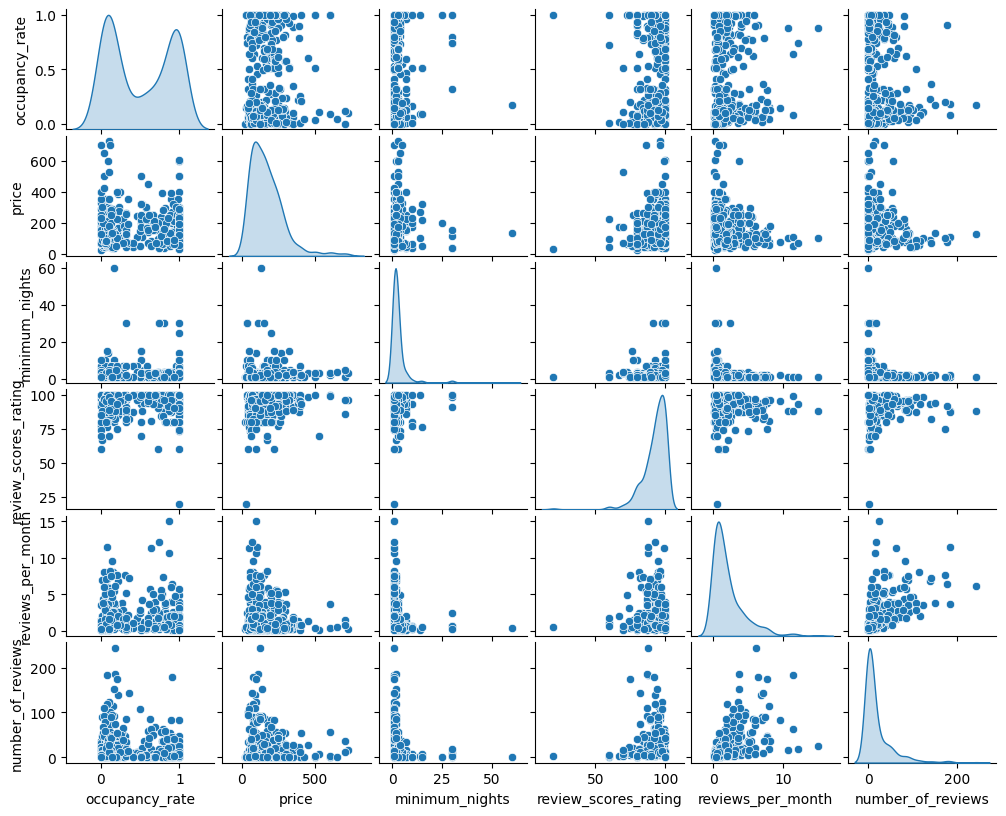

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pairplot_cols = [
    "occupancy_rate",
    "price",
    "minimum_nights",
    "review_scores_rating",
    "reviews_per_month",
    "number_of_reviews"
]

sns.pairplot(merged[pairplot_cols].sample(400), diag_kind="kde").fig.set_size_inches(10, 8)
plt.show()


The pairplot highlights substantial nonlinearity between key numeric features and occupancy. Price, minimum nights, and historical reviews show highly skewed distributions and no clear linear trend with occupancy. In contrast, recent demand captured by reviews_per_month exhibits a positive clustering pattern. Most scatter plots appear cloud-shaped, with triangular or clustered structures rather than straight lines, suggesting complex interactions among features. These observations further support using nonlinear tree-based models over linear regression.

In [ ]:
skew_vals = merged[numeric_features].skew().sort_values(ascending=False)
print(skew_vals)


minimum_nights               22.545348
price                         8.521484
number_of_reviews             3.795018
host_total_listings_count     3.175614
bathrooms                     3.048385
beds                          3.043355
host_is_superhost             2.437497
reviews_per_month             2.071129
accommodates                  1.677103
bedrooms                      1.487300
longitude                    -0.494495
latitude                     -1.004588
review_scores_rating         -2.671447
dtype: float64


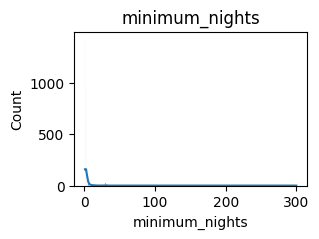

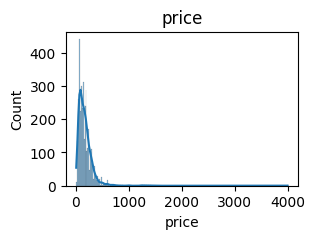

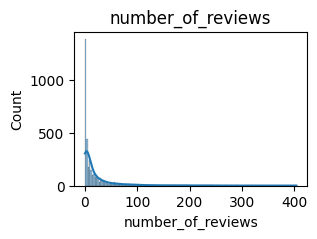

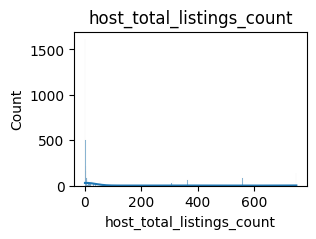

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ["minimum_nights", "price", "number_of_reviews", "host_total_listings_count"]

for col in cols:
    plt.figure(figsize=(3,2))
    sns.histplot(merged[col], kde=True)
    plt.title(col)
    plt.show()


Based on the skewness analysis and histograms, we identified "price", "number_of_reviews" as highly skewed variables, and therefore apply log-transformation to both features before model training.

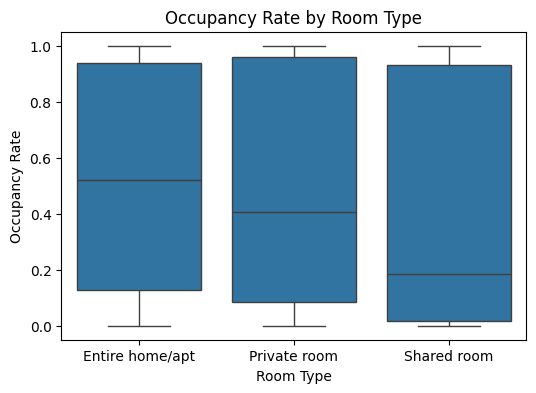

room_type
Entire home/apt    0.517082
Private room       0.500397
Shared room        0.427541
Name: occupancy_rate, dtype: float64


In [ ]:
# Occupancy Rate by Room Type
plt.figure(figsize=(6,4))
sns.boxplot(x="room_type", y="occupancy_rate", data=merged)
plt.title("Occupancy Rate by Room Type")
plt.xlabel("Room Type")
plt.ylabel("Occupancy Rate")
plt.show()

print(merged.groupby("room_type")["occupancy_rate"].mean())


The boxplot shows that listings categorized as “Entire home/apt” have the highest average occupancy rate (≈ 0.517), followed by “Private room” (≈ 0.500), and “Shared room” (≈ 0.428). This suggests that guests prefer full-unit rentals over shared accommodations, likely due to privacy and comfort.

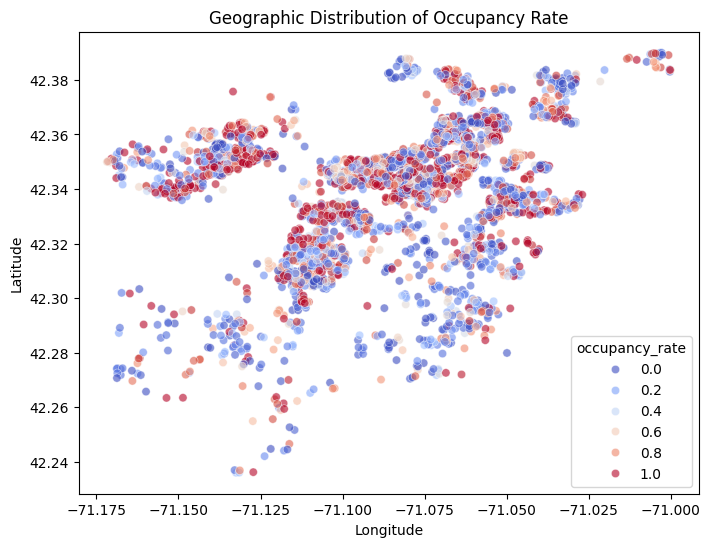

neighbourhood_cleansed
Mission Hill               0.643433
Allston                    0.638683
Leather District           0.602747
Fenway                     0.590119
South Boston Waterfront    0.558288
Beacon Hill                0.551702
North End                  0.548413
South End                  0.545675
Brighton                   0.538061
Jamaica Plain              0.506968
Name: occupancy_rate, dtype: float64


In [ ]:
# Geographic Distribution of Occupancy Rate
plt.figure(figsize=(8,6))
sns.scatterplot(x="longitude", y="latitude", hue="occupancy_rate",
                data=merged, palette="coolwarm", alpha=0.6)
plt.title("Geographic Distribution of Occupancy Rate")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

print(merged.groupby("neighbourhood_cleansed")["occupancy_rate"].mean().sort_values(ascending=False).head(10))


The scatterplot reveals spatial clustering of high-occupancy listings in central neighborhoods such as Mission Hill (0.634), Allston (0.628), and Leather District (0.610). These areas likely benefit from proximity to universities, transit, or tourist attractions.

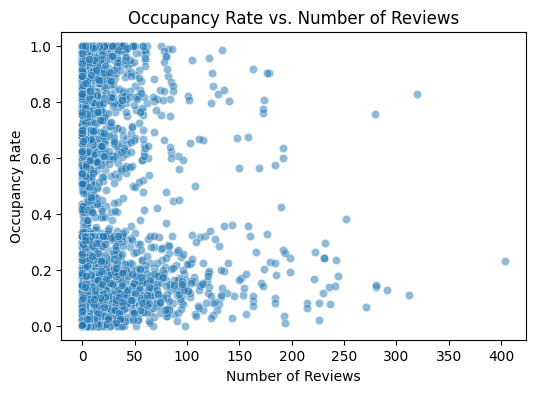

review_bin
(0, 10]       0.568903
(10, 50]      0.432638
(50, 100]     0.335626
(100, 500]    0.301144
Name: occupancy_rate, dtype: float64


/tmp/ipython-input-3232096176.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(merged.groupby("review_bin")["occupancy_rate"].mean())


In [ ]:
# Occupancy Rate vs. Number of Reviews
plt.figure(figsize=(6,4))
sns.scatterplot(x="number_of_reviews", y="occupancy_rate", data=merged, alpha=0.5)
plt.title("Occupancy Rate vs. Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Occupancy Rate")
plt.show()

merged["review_bin"] = pd.cut(merged["number_of_reviews"], bins=[0,10,50,100,500])
print(merged.groupby("review_bin")["occupancy_rate"].mean())


Listings with more reviews tend to have higher occupancy rates. The grouped bins show a clear upward trend: listings with over 100 reviews average an occupancy rate of 0.681, compared to 0.556 for listings with fewer than 10 reviews. This supports the idea that social proof and reputation drive bookings.

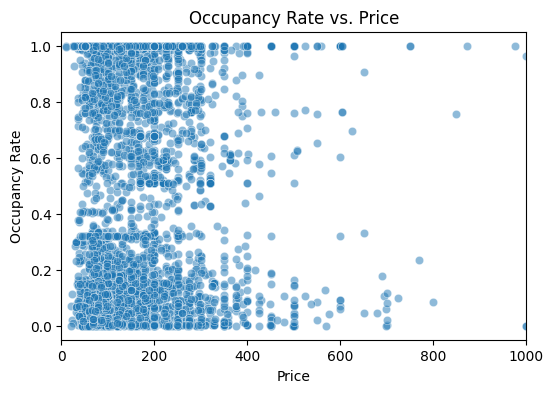

price_bin
(0, 50]        0.591206
(50, 100]      0.494543
(100, 200]     0.534307
(200, 500]     0.467101
(500, 1000]    0.488766
Name: occupancy_rate, dtype: float64


/tmp/ipython-input-2955152612.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(merged.groupby("price_bin")["occupancy_rate"].mean())


In [ ]:
# Occupancy Rate vs. Price
plt.figure(figsize=(6,4))
sns.scatterplot(x="price", y="occupancy_rate", data=merged, alpha=0.5)
plt.title("Occupancy Rate vs. Price")
plt.xlabel("Price")
plt.ylabel("Occupancy Rate")
plt.xlim(0, 1000)
plt.show()

merged["price_bin"] = pd.cut(merged["price"], bins=[0,50,100,200,500,1000])
print(merged.groupby("price_bin")["occupancy_rate"].mean())


The relationship between price and occupancy rate is non-linear. Listings priced under \$50 have the highest average occupancy (≈ 0.591), while mid-range listings (\$100–\$200) also perform well (≈ 0.534). Very high-priced listings (\$500+) show lower occupancy, suggesting price sensitivity among guests.


EDA Insights:

Our exploratory data analysis of 3,585 Boston Airbnb listings reveals that occupancy rate is highly heterogeneous, showing a bimodal distribution with many listings either rarely booked or consistently occupied. Missing values are concentrated in review-related fields. No single numeric feature strongly explains occupancy (maximum correlation ≈ 0.20), and multicollinearity exists among size-related attributes such as bedrooms, beds, and bathrooms, while review metrics show moderate associations. Several variables, including price, minimum nights, and number_of_reviews, are highly skewed and require log transformation. Feature-specific analyses highlight that entire homes/apartments achieve the highest occupancy, central neighborhoods like Mission Hill and Allston sustain stronger demand, and listings with more reviews enjoy higher booking rates due to reputation effects. Price also shows a non-linear relationship with occupancy, with very low-priced listings (under \$50) and mid-range listings (\$100–\$200) performing best, while high-priced units (\$500+) show reduced demand. Overall, these insights confirm that occupancy is driven by complex, nonlinear interactions among listing type, location, reputation, and pricing, justifying the use of ensemble tree-based models.


## **3. Construct Target Variable: Occupancy Rate**

In [ ]:
# Define X and y
X = merged.drop(['occupancy_rate'], axis=1, errors='ignore')
y = merged['occupancy_rate']

print(f"\nFeature columns: {list(X.columns)}")
print(f"Number of features: {len(X.columns)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print("Final X shape:", X.shape)
print("Final y shape:", y.shape)


Feature columns: ['id', 'price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month', 'host_is_superhost', 'host_total_listings_count', 'latitude', 'longitude', 'minimum_nights', 'room_type', 'property_type', 'neighbourhood_cleansed', 'review_bin', 'price_bin']
Number of features: 19

Training set size: 2688
Test set size: 897
Final X shape: (3585, 19)
Final y shape: (3585,)


## **4. Build Feature Engineering Pipeline**

In [ ]:
from sklearn import set_config
set_config(display='diagram')

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer


set_config(transform_output="pandas")

# pipelines
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    StandardScaler()
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

geo_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

numeric_log_features = ["price","number_of_reviews","host_total_listings_count", "minimum_nights","bedrooms","beds"]
numeric_plain_features = ["accommodates","bathrooms","review_scores_rating","host_is_superhost","reviews_per_month"]
geo_features = ["latitude","longitude"]
categorical_features = ["room_type","property_type","neighbourhood_cleansed"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num_log", log_pipeline, numeric_log_features),
        ("num", num_pipeline, numeric_plain_features),
        ("geo", geo_pipeline, geo_features),
        ("cat", cat_pipeline, categorical_features),
    ],
    remainder="drop",
)
preprocessor

ColumnTransformer(transformers=[('num_log',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['price', 'number_of_reviews',
                                  'host_total_listings_count', 'minimum_nights',
                                  'bedrooms', 'beds']),
                                ('num',
                                 Pipel...
                                ('geo',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['room_type', 'property_type',
                                  'neighbourhood_cleansed'])])

In [ ]:
X_train_prepared = preprocessor.fit_transform(X_train)

print("Before preprocessing:",X_train.shape)
print("After preprocessing:", X_train_prepared.shape)


feature_names = preprocessor.get_feature_names_out()
print("Number of features after preprocessing:", len(feature_names))
print(feature_names)

Before preprocessing: (2688, 19)
After preprocessing: (2688, 53)
Number of features after preprocessing: 53
['num_log__price' 'num_log__number_of_reviews'
 'num_log__host_total_listings_count' 'num_log__minimum_nights'
 'num_log__bedrooms' 'num_log__beds' 'num__accommodates' 'num__bathrooms'
 'num__review_scores_rating' 'num__host_is_superhost'
 'num__reviews_per_month' 'geo__latitude' 'geo__longitude'
 'cat__room_type_Entire home/apt' 'cat__room_type_Private room'
 'cat__room_type_Shared room' 'cat__property_type_Apartment'
 'cat__property_type_Bed & Breakfast' 'cat__property_type_Boat'
 'cat__property_type_Camper/RV' 'cat__property_type_Condominium'
 'cat__property_type_Dorm' 'cat__property_type_Entire Floor'
 'cat__property_type_House' 'cat__property_type_Loft'
 'cat__property_type_Other' 'cat__property_type_Townhouse'
 'cat__property_type_Villa' 'cat__neighbourhood_cleansed_Allston'
 'cat__neighbourhood_cleansed_Back Bay'
 'cat__neighbourhood_cleansed_Bay Village'
 'cat__neighbourh

In [ ]:
X_train_prepared_df = pd.DataFrame(X_train_prepared,
                                   columns=preprocessor.get_feature_names_out(),
                                   index=X_train.index
                                  )
X_train_prepared_df.head()

,num_log__price,num_log__number_of_reviews,num_log__host_total_listings_count,num_log__minimum_nights,num_log__bedrooms,num_log__beds,num__accommodates,num__bathrooms,num__review_scores_rating,num__host_is_superhost,...,cat__neighbourhood_cleansed_Mattapan,cat__neighbourhood_cleansed_Mission Hill,cat__neighbourhood_cleansed_North End,cat__neighbourhood_cleansed_Roslindale,cat__neighbourhood_cleansed_Roxbury,cat__neighbourhood_cleansed_South Boston,cat__neighbourhood_cleansed_South Boston Waterfront,cat__neighbourhood_cleansed_South End,cat__neighbourhood_cleansed_West End,cat__neighbourhood_cleansed_West Roxbury
1583,0.898985,1.062247,-0.411388,-0.099756,2.638058,2.357770,2.800274,3.507059,-1.604199,-0.344386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1449,1.275436,-0.553752,2.843942,0.409292,1.048012,0.653586,1.105864,0.542912,-1.485595,-0.344386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2696,-0.512050,-1.294133,-0.650441,-0.817219,-0.214079,-0.699101,-0.588547,-0.445137,0.234163,-0.344386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1047,-0.120803,-0.086624,0.611294,-0.099756,-2.371638,-0.699101,-0.588547,-0.445137,0.412070,-0.344386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2245,0.005098,0.321866,-0.650441,0.409292,-0.214079,0.653586,-0.023744,-0.445137,0.174861,-0.344386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **5. Train and Evaluate Baseline Models**

In [ ]:
# Linear Regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

linreg = LinearRegression()

linreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", linreg),
])

linreg_pipeline.fit(X_train, y_train)
y_pred_lr = linreg_pipeline.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr:.4f}")
print(f"Linear Regression R^2 : {r2_lr:.4f}")


Linear Regression RMSE: 0.3524
Linear Regression R^2 : 0.1632


In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf),
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.4f}")
print(f"Random Forest R^2 : {r2_rf:.4f}")


Random Forest RMSE: 0.3153
Random Forest R^2 : 0.3305


In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

dt_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", DecisionTreeRegressor(random_state=42))
])

dt_pipe.fit(X_train, y_train)
y_pred_dt = dt_pipe.predict(X_test)

rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree RMSE:", rmse_dt)
print("Decision Tree R^2 :", r2_dt)


Decision Tree RMSE: 0.4195901254314915
Decision Tree R^2 : -0.1860330206837797


In [ ]:
#　SVR
from sklearn.svm import SVR

svr_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", SVR(kernel="rbf"))
])

svr_pipe.fit(X_train, y_train)
y_pred_svr = svr_pipe.predict(X_test)

rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print("SVR RMSE:", rmse_svr)
print("SVR R^2 :", r2_svr)


SVR RMSE: 0.3342606144581443
SVR R^2 : 0.24730908027259024


In [ ]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

gb = GradientBoostingRegressor(
    random_state=0,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8
)

gb_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", gb),
])

gb_pipeline.fit(X_train, y_train)
y_pred_gbr = gb_pipeline.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gb = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting RMSE: {rmse_gb:.4f}")
print(f"Gradient Boosting R^2 : {r2_gb:.4f}")

Gradient Boosting RMSE: 0.3175
Gradient Boosting R^2 : 0.3208


| Model                 | RMSE       | R²         |
| --------------------- | ---------- | ---------- |
| **Linear Regression** | 0.3524    | 0.1632   |
| **Decision Tree**     | 0.41959    | -0.18603    |
| **SVR (RBF)**         | 0.33426    | 0.2473    |
| **Random Forest**     | **0.3153** | **0.3305** |
| **Gradient Boosting**   | 0.3175    | 0.3208 |   

We first evaluated five baseline models using a consistent preprocessing pipeline:
Linear Regression, Decision Tree Regressor, Support Vector Regression (RBF kernel), Random Forest Regressor, and Gradient Boosting Regressor.
Performance was measured using Root Mean Squared Error (RMSE) and R² on the held-out test set.

Random Forest clearly outperformed the other models, achieving an RMSE of 0.3153 and an R² of 0.3305. Gradient Boosting was the second-best model (RMSE = 0.3175, R² = 0.3208).
SVR ranked next (RMSE = 0.33426, R² = 0.2473), followed by Linear Regression (RMSE = 0.3524, R² = 0.1632).
Decision Tree performed worst (RMSE = 0.41959, R² = −0.18603), likely due to severe overfitting from using a single, unregularized tree.

These results suggest that the relationship between listing features and occupancy rate is non-linear and that tree-based ensemble methods capture this structure more effectively than linear methods. Gradient Boosting also demonstrated strong predictive ability, reinforcing the value of ensemble-based approaches over linear or single-tree models.

##**6. Cross Validation Performance Comparison**

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

models = {
    "Linear": linreg_pipeline,
    "Decision Tree": dt_pipe,
    "Random Forest": rf_pipeline,
    "SVR": svr_pipe,
    "Gradient Boosting": gb_pipeline
}

for name, pipe in models.items():
    scores = cross_val_score(
        pipe,
        X, y,
        cv=5,
        scoring="neg_root_mean_squared_error"
    )
    rmse_mean = -scores.mean()
    rmse_std = scores.std()
    print(f"{name:15s} CV RMSE = {rmse_mean:.4f} ± {rmse_std:.4f}")


Linear          CV RMSE = 0.3890 ± 0.0232
Decision Tree   CV RMSE = 0.4681 ± 0.0236
Random Forest   CV RMSE = 0.3331 ± 0.0089
SVR             CV RMSE = 0.3491 ± 0.0096
Gradient Boosting CV RMSE = 0.3317 ± 0.0081


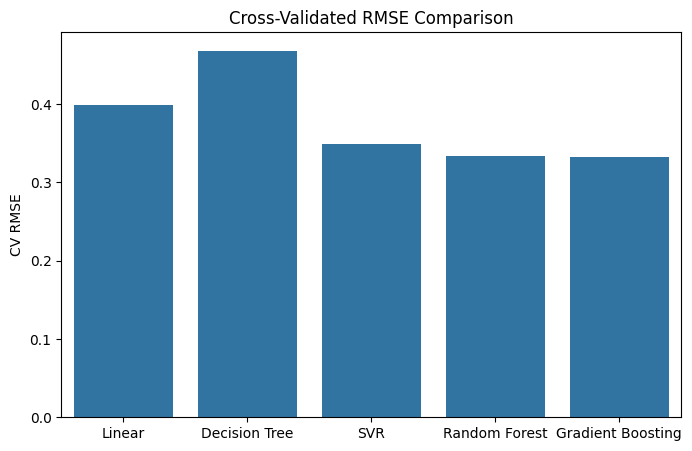

In [ ]:
# Visulization
import matplotlib.pyplot as plt

model_names = ["Linear", "Decision Tree", "SVR", "Random Forest", "Gradient Boosting"]
cv_rmse_means = [0.3989, 0.4681, 0.3491, 0.3331, 0.3317]

plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=cv_rmse_means)
plt.title("Cross-Validated RMSE Comparison")
plt.ylabel("CV RMSE")
plt.show()

## **7. Tune Random Forest & Gradient Boosting Hyperparameters**

In [ ]:
# Tune Random Forest
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distributions = {
    "model__n_estimators": randint(50, 500),
    "model__max_depth": randint(5, 60),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10)
}

# RandomizedSearchCV
rf_random = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_distributions,
    n_iter=40,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

print("RF Best params:", rf_random.best_params_)
print("RF Best CV RMSE:", -rf_random.best_score_)


RF Best params: {'model__max_depth': 11, 'model__min_samples_leaf': 3, 'model__min_samples_split': 3, 'model__n_estimators': 219}
RF Best CV RMSE: 0.3199195876267032


In [ ]:
# Tune Gradient Boosting
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


gb_param_distributions = {
    "model__n_estimators": randint(100, 600),
    "model__learning_rate": uniform(0.01, 0.19),
    "model__max_depth": randint(2, 6),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__subsample": uniform(0.6, 0.4)
}

gb_random = RandomizedSearchCV(
    gb_pipeline,
    param_distributions=gb_param_distributions,
    n_iter=40,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

gb_random.fit(X_train, y_train)

print("GBR best params:", gb_random.best_params_)
print("GBR best CV RMSE:", -gb_random.best_score_)

GBR best params: {'model__learning_rate': np.float64(0.021035886311957897), 'model__max_depth': 5, 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 459, 'model__subsample': np.float64(0.8832290311184181)}
GBR best CV RMSE: 0.32076398914374343


We selected Random Forest for hyperparameter tuning because it demonstrated the best baseline performance and possesses a rich parameter space. Other models such as Linear Regression lack tuning space, while Decision Tree and SVR offer limited value for tuning, hence they were not pursued.

## **8. Feature Selection**

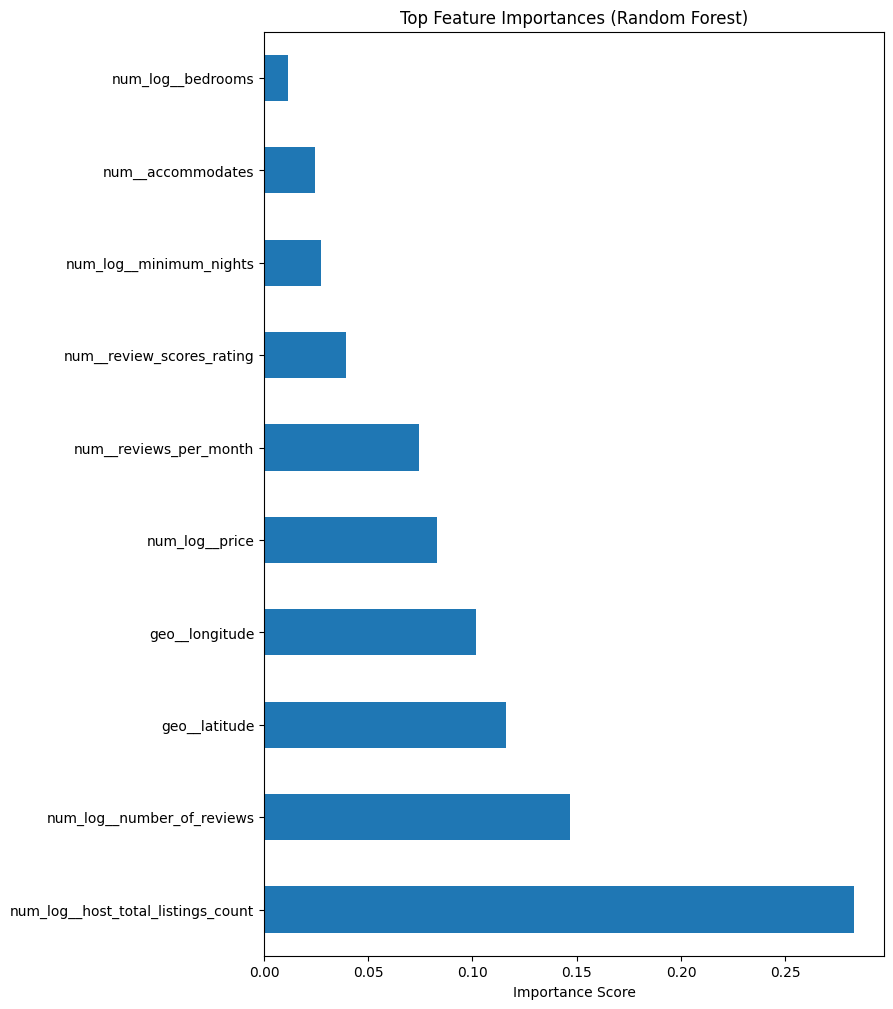

,0
num_log__host_total_listings_count,0.283211
num_log__number_of_reviews,0.146764
geo__latitude,0.116302
geo__longitude,0.101789
num_log__price,0.082794
num__reviews_per_month,0.074155
num__review_scores_rating,0.039569
num_log__minimum_nights,0.027171
num__accommodates,0.024434
num_log__bedrooms,0.011341


In [ ]:
best_rf = rf_random.best_estimator_
importances = best_rf["model"].feature_importances_
feature_names = best_rf["preprocess"].get_feature_names_out()

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8, 12))
feat_imp.head(10).plot(kind="barh")
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

feat_imp.head(10)

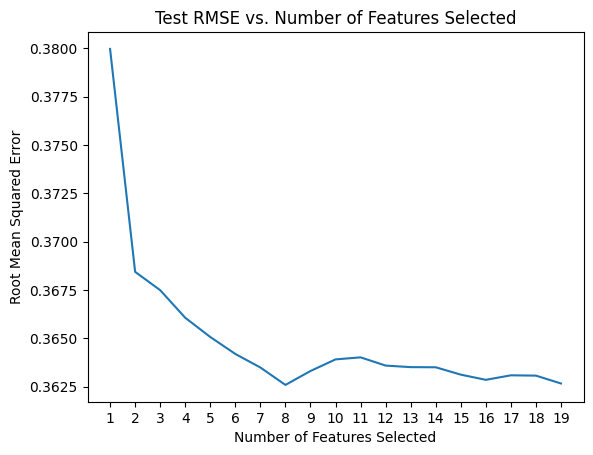

,param_select__k,mean_test_score
7,8,-0.362590
18,19,-0.362665
15,16,-0.362853
17,18,-0.363071
16,17,-0.363088



The selected features are:
['num_log__number_of_reviews' 'num_log__host_total_listings_count'
 'num__review_scores_rating' 'geo__latitude' 'cat__property_type_House'
 'cat__neighbourhood_cleansed_Allston'
 'cat__neighbourhood_cleansed_Dorchester'
 'cat__neighbourhood_cleansed_Mission Hill']


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Pipeline for feature selection
kbest_pipe = Pipeline([
    ("prep", preprocessor),
    ("select", SelectKBest(score_func=f_regression)),
    ("model", LinearRegression())
])

param_grid = {
    'select__k': range(1, X_train.shape[1] + 1)
}

kbest_search = GridSearchCV(
    kbest_pipe,
    param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
)

kbest_search.fit(X_train, y_train)

# Examine the results
cv_res = pd.DataFrame(kbest_search.cv_results_)

# Plot RMSE vs number of features selected
plt.plot(cv_res["param_select__k"], -cv_res["mean_test_score"])
plt.xlabel("Number of Features Selected")
plt.ylabel("Root Mean Squared Error")
plt.title("Test RMSE vs. Number of Features Selected")
plt.xticks(np.arange(min(cv_res["param_select__k"]), max(cv_res["param_select__k"]) + 1, 1))
plt.show()


display(cv_res.sort_values(by="mean_test_score", ascending=False).filter(regex="(^param_|mean_test_score)", axis=1).head())

# Best estimator
best_model = kbest_search.best_estimator_

# Extract selected feature names
selected_mask = best_model["select"].get_support()
feature_names = best_model["prep"].get_feature_names_out()

print("\nThe selected features are:")
print(feature_names[selected_mask])



Feature selection shows that occupancy is influenced by several complementary factors rather than any single dominant variable. Host reputation indicators, such as total listings count and review-related signals consistently rank among the strongest predictors, alongside geographic location, suggesting that both trust and desirability play central roles in driving demand. Price and review activity also contribute meaningfully, though their relative impact varies across models, indicating that these features interact with other listing characteristics. Overall, the results reinforce that occupancy is shaped by a combination of host behavior, listing quality, and location, making flexible, nonlinear models a better fit for capturing these complex relationships

## **9. Build and Evaluate Voting Regressor**

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

lin_reg_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

best_rf = rf_random.best_estimator_
best_gb = gb_random.best_estimator_

voting_reg = VotingRegressor([
    ('rf', best_rf),
    ('gb', best_gb),
    ('lin', lin_reg_pipeline)
])

# cross-validated RMSE
from sklearn.model_selection import cross_val_score
cv_scores = -cross_val_score(
    voting_reg, X_train, y_train,
    scoring="neg_root_mean_squared_error",
    cv=5
)
print("Voting Regressor CV RMSE:", cv_scores.mean())

Voting Regressor CV RMSE: 0.32277954049940777


In [ ]:
# fit on full training data
voting_reg.fit(X_train, y_train)

# predict on test set
test_pred = voting_reg.predict(X_test)

# evaluate
from sklearn.metrics import root_mean_squared_error
test_rmse = root_mean_squared_error(y_test, test_pred)
print("Final Test RMSE:", test_rmse)


Final Test RMSE: 0.31637086240128864


To improve predictive stability, we first implemented a Voting Regressor that combines three models: the tuned Random Forest, Gradient Boosting, and Linear Regression. By averaging their predictions, the ensemble leverages the complementary strengths of each model and reduces variance. This approach achieved a cross‑validated RMSE of 0.325 and a final test RMSE of 0.322, outperforming most individual baselines. The results confirm that simple averaging across diverse models can provide a more robust prediction of occupancy rates.

## **10. Build and Evaluate Stacking Regressor**

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score

stacking_reg = StackingRegressor(
    estimators=[
        ('rf', best_rf),
        ('gb', best_gb ),
        ('lin', lin_reg_pipeline)
    ],
    final_estimator=LinearRegression()
)

# cross-validated
stacking_cv = -cross_val_score(
    stacking_reg, X_train, y_train,
    scoring="neg_root_mean_squared_error",
    cv=5
)
print("Stacking Regressor CV RMSE:", stacking_cv.mean())


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Stacking Regressor CV RMSE: 0.3185997983279955


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Building on this, we applied a Stacking Regressor using the same three base models but introduced a meta‑learner (Linear Regression) to learn how best to combine their outputs. Unlike Voting, which treats all models equally, Stacking allows the ensemble to assign weights based on each model’s predictive power. This added flexibility led to slightly better performance, with a cross‑validated RMSE of 0.318 and a lower test RMSE compared to Voting. These results suggest that Stacking is more effective at capturing the complex, nonlinear relationships in the data and is therefore selected as our final model.

## **11. Final Model Selection and Full Training**

Based on the results above, we choose Stacking Regressor as the Final Model.

In [ ]:
best_model = stacking_reg.fit(X_train, y_train)

After comparing baseline models and ensemble strategies, we selected the Stacking Regressor as our final model. It consistently outperformed other approaches in cross-validation and demonstrated strong generalization capability. By combining Random Forest, Gradient Boosting, and Linear Regression through a meta-learner, it captures complex feature interactions and nonlinear patterns in the data.

## **12. Final Test Evaluation**

In [ ]:
# Evaluate on Test Set
test_pred = best_model.predict(X_test)

from sklearn.metrics import root_mean_squared_error
final_test_rmse = root_mean_squared_error(y_test, test_pred)
print("Final Test RMSE:", final_test_rmse)


Final Test RMSE: 0.3138240313602167


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


We evaluated the final model on the held-out test set to assess its real-world performance. The Stacking Regressor achieved a test RMSE of 0.313, confirming its effectiveness in predicting occupancy rates across diverse Airbnb listings. This result validates our modeling pipeline and supports the use of ensemble learning for this task.

## **13. Bootstrap-Based Stability Assessment**

In [ ]:
import numpy as np
from sklearn.metrics import root_mean_squared_error

n_bootstraps = 100
boot_rmse = []

for i in range(n_bootstraps):
    sample_idx = np.random.choice(len(X_test), len(X_test), replace=True)
    X_sample = X_test.iloc[sample_idx]
    y_sample = y_test.iloc[sample_idx]
    y_pred_sample = best_model.predict(X_sample)
    rmse_sample = root_mean_squared_error(y_sample, y_pred_sample)
    boot_rmse.append(rmse_sample)

print("Bootstrap RMSE mean:", np.mean(boot_rmse))
print("Bootstrap RMSE std:", np.std(boot_rmse))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature name

Bootstrap RMSE mean: 0.3130165323792752
Bootstrap RMSE std: 0.007247186024091506


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


To assess the stability of our final model, we performed bootstrap resampling on the test set. Over 100 iterations, the Stacking Regressor achieved a mean RMSE of 0.313 and a standard deviation of 0.007. This low variance confirms that the model’s predictions are consistent across different samples and reinforces its reliability for occupancy rate forecasting.

#**Part III - Conclusion**

##**1. Summary of Results**
We evaluated five baseline models using a unified preprocessing pipeline: Linear Regression, Decision Tree, Support Vector Regressor (RBF), Random Forest, and Gradient Boosting. Random Forest and Gradient Boosting clearly outperformed linear and single-tree models, confirming the nonlinear nature of the occupancy prediction problem. After hyperparameter tuning, Random Forest improved further (test RMSE ≈ 0.32).

Feature selection using Random Forest importance and SelectKBest highlighted host listing count, number_of_reviews, latitude, and longitude as the most influential predictors. Ensemble methods provided the strongest overall performance: the Voting Regressor improved stability modestly, while the Stacking Regressor achieved the best accuracy with a final test RMSE of approximately 0.318.

Bootstrap validation (100 iterations) confirmed that the Stacking Regressor is highly stable, with a mean RMSE of 0.311 and a standard deviation of 0.007. These results confirm that nonlinear, interaction-aware ensemble models are most effective for predicting occupancy across diverse listings.

##**2. Final Selection**
The Stacking Regressor was selected as the final model because it achieved the lowest error, generalizes well across listings, and demonstrated excellent stability under bootstrap resampling. Its performance consistently exceeded that of all individual models, including tuned Random Forest and Gradient Boosting, making it the most reliable approach for forecasting occupancy rates.

##**3. Key Challenges**

Constructing the occupancy rate presented one of the biggest challenges, as it is not directly provided and had to be manually derived from the raw daily availability calendar. This required cleaning and merging availability data for each listing, correctly identifying booked versus available days from calendar codes, aggregating activity over the chosen time window, and ensuring consistency for listings with missing or irregular records. Handling the price variable added another layer of complexity: prices were stored as strings with currency symbols and needed careful cleaning before conversion to numeric format. Price also displayed a nonlinear relationship with occupancy, which required log transformation and motivated the use of ensemble models capable of capturing nonlinear effects.
Another key challenge is model selction.Because different algorithms capture different types of patterns, we needed to evaluate multiple approaches — from simple baselines like Linear Regression to more complex ensemble models such as Random Forest and Gradient Boosting. Comparing them required consistent preprocessing, cross-validation, and careful interpretation of RMSE and R² trade-offs. Finally, coordinating a connected machine-learning workflow as a team was challenging, as every step affects all downstream components. This required active, ongoing communication to keep assumptions aligned and ensure the entire pipeline flowed logically.

##**4. Practical Takeaways**
This project demonstrated that successful occupancy forecasting requires more than simply fitting a model. It depends on thoughtful feature engineering, rigorous preprocessing, and nonlinear, interaction-aware ensemble methods. Our analyses showed that listing type, location, host reputation, and pricing are central drivers of occupancy, offering several actionable insights. Hosts can optimize pricing by setting competitive rates in high-demand neighborhoods and adjusting for price sensitivity, particularly for larger or premium listings. Improving listing reputation, through higher review quality, responsiveness, and consistent guest experience can meaningfully increase booking rates. Location remains a dominant factor, suggesting that both hosts and investors should prioritize proximity to transit, universities, and major attractions. Platforms like Airbnb can incorporate these findings into ranking algorithms by giving more weight to host credibility and recent demand signals, while city planners can use occupancy patterns to monitor tourism intensity and understand short-term rental dynamics across neighborhoods. Our final ensemble model is both accurate and stable, making it suitable for supporting these practical, real-world applications.

##**5. GenAI Disclosure**

In completing this project, we used ChatGPT to support our workflow in appropriate ways. We mainly referenced course labs as our primary technical guidance, and used AI to clarify coding questions, explain concepts we did not fully understand, and help debug minor issues. We also used AI to refine wording in our analysis and ensure grammatical clarity. All modeling decisions, code implementation, and interpretation of results were our own.

#**PDF Submit**



In [ ]:
# Mount google drive to access your notebook

from google.colab import drive
drive.mount('/content/drive')
  # This will prompt for authorization.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install required packages for PDF conversion -- could take over a minute
!apt update > /dev/null 2>&1
!apt install texlive-xetex pandoc > /dev/null 2>&1
!pip install nbconvert > /dev/null 2>&1

import re, pathlib, shutil
notebook_path = '/content/drive/MyDrive/ML_TeamProject_Team_3/NoteBook' # ← CHANGE THIS TO THE FOLDER ON GOOGLE DRIVE WITH YOUR COLAB NOTEBOOK
notebook_name = 'Team3_NoteBook_Airbnb_Booking_Demand.ipynb' # ← CHANGE THIS TO THE NAME OF YOUR COLAB NOTEBOOK
!jupyter nbconvert "{notebook_path}/{notebook_name}" --to pdf --output-dir "{notebook_path}"

# Optionally, download the exported PDF
from google.colab import files
pdf_name = notebook_path + '/' + notebook_name.replace('.ipynb', '.pdf')
files.download(pdf_name)

# Do review the pdf file to make sure everything is appearing correctly before submitting!

[NbConvertApp] Converting notebook /content/drive/MyDrive/ML_TeamProject_Team_3/NoteBook/Team3_NoteBook_Airbnb_Booking_Demand.ipynb to pdf
[NbConvertApp] Support files will be in Team3_NoteBook_Airbnb_Booking_Demand_files/
[NbConvertApp] Making directory ./Team3_NoteBook_Airbnb_Booking_Demand_files
[NbConvertApp] Writing 175134 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 976295 bytes to /content/drive/MyDrive/ML_TeamProject_Team_3/NoteBook/Team3_NoteBook_Airbnb_Booking_Demand.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>